<a href="https://www.kaggle.com/code/patimejia/insights-dnn-diagnostics-activations-gradients?scriptVersionId=138075467" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---

> #### **Goal**: This code is designed for analysis of deep neural networks. Through visualizing activations, weights, and gradients, we identify issues stemming from activation functions. Much like the length of a pendulum determines its swing frequency, (i.e. $\frac{1}{t_{j-i}}$ hertz), activation functions shape a network's reaction to data.

---
# Deep Neural Networks: Addressing the Gradient Problem

Deep neural networks are powerful tools in machine learning. However, training them can present challenges. One notable challenge is the vanishing and exploding gradient problem during backpropagation. The choice of activation functions can significantly influence these issues.

## Activation Functions

Activation functions introduce non-linearity into the network, enabling it to learn from the error and make adjustments, which is essential for learning complex patterns.

### 1. Sigmoid
 $$f(x) = \frac{1}{1 + e^{-x}} $$
- **Range**: [0, 1]
- **Challenge**: Can lead to vanishing gradients in deep networks due to its saturation for large positive or negative inputs.
- **Gradient**: 
 $\frac{\partial f(x)}{\partial x} = f(x)(1 - f(x)) $

### 2. ReLU (Rectified Linear Unit)
$$ f(x) = \max(0, x) $$
- **Range**: $[0, \infty)$
- **Benefit**: Mitigates the vanishing gradient problem.
- **Challenge**: Can lead to exploding gradients if not carefully initialized or regularized.

### 3. Leaky ReLU
$$f(x) = 
\begin{cases} 
x & \text{if } x > 0 \\
\alpha x & \text{otherwise}
\end{cases} 
$$
- **Range**: $(- \infty, \infty)$
- **Benefit**: Addresses the "dying ReLU" problem where neurons never activate.
- **Parameter**: $\alpha$ is a small positive constant (e.g., $0.01$).

### 4. Tanh
$$ f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
- **Range**: $[-1, 1]$
- **Note**: It's a scaled and shifted version of the sigmoid function. In fact, it scales the sigmoid's output by 2 and shifts it down by 1.

### 5. Arctangent
$$ f(x) = \arctan(x) $$
- **Range**: $[- \frac{\pi}{2}, \frac{\pi}{2}]$

## Gradient Dynamics

- **Vanishing Gradient**: Occurs when gradients approach zero, stalling the training process. Often observed with activation functions that squash their inputs into a small range, especially when inputs are large.

- **Exploding Gradient**: Occurs when gradients grow too large, causing divergent behavior. This can be due to deep networks, large parameter values, or particular activation functions.

## Mitigating Strategies

1. **Proper Initialization**: Initialize weights in a manner that neither amplifies nor diminishes gradients during backpropagation.
2. **Shortcuts/Residual connections**: Used in architectures like ResNets, these allow gradients to skip layers and mitigate the vanishing gradient issue.
3. **Gradient Clipping**: A technique to prevent gradients from exceeding a threshold and thus prevent the exploding gradient problem.

## Diagnostic Code

The code provided is a tool designed to help visualize the behavior of different activation functions in deep neural networks. By examining activations, weights, and gradients, we can gain insight into and potentially address the challenges associated with them.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l


[LEAKY_RELU] Extracting neuron activations (outputs) for input data [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]. This helps us understand how data flows through the network.

[LEAKY_RELU] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[LEAKY_RELU] Computing gradients to understand how much the error will change if the weights are adjusted. This is crucial for learning.

[LEAKY_RELU] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[LEAKY_RELU] Computing gradients to understand how much the error will change if the weights are adjusted. This is crucial for learning.

[LEAKY_RELU] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[LEAKY_RELU] Checking for potential gradient issues like vanishing or exploding gradients which can hinder learning.
[Warning] leaky_relu has potential vanishing gradien

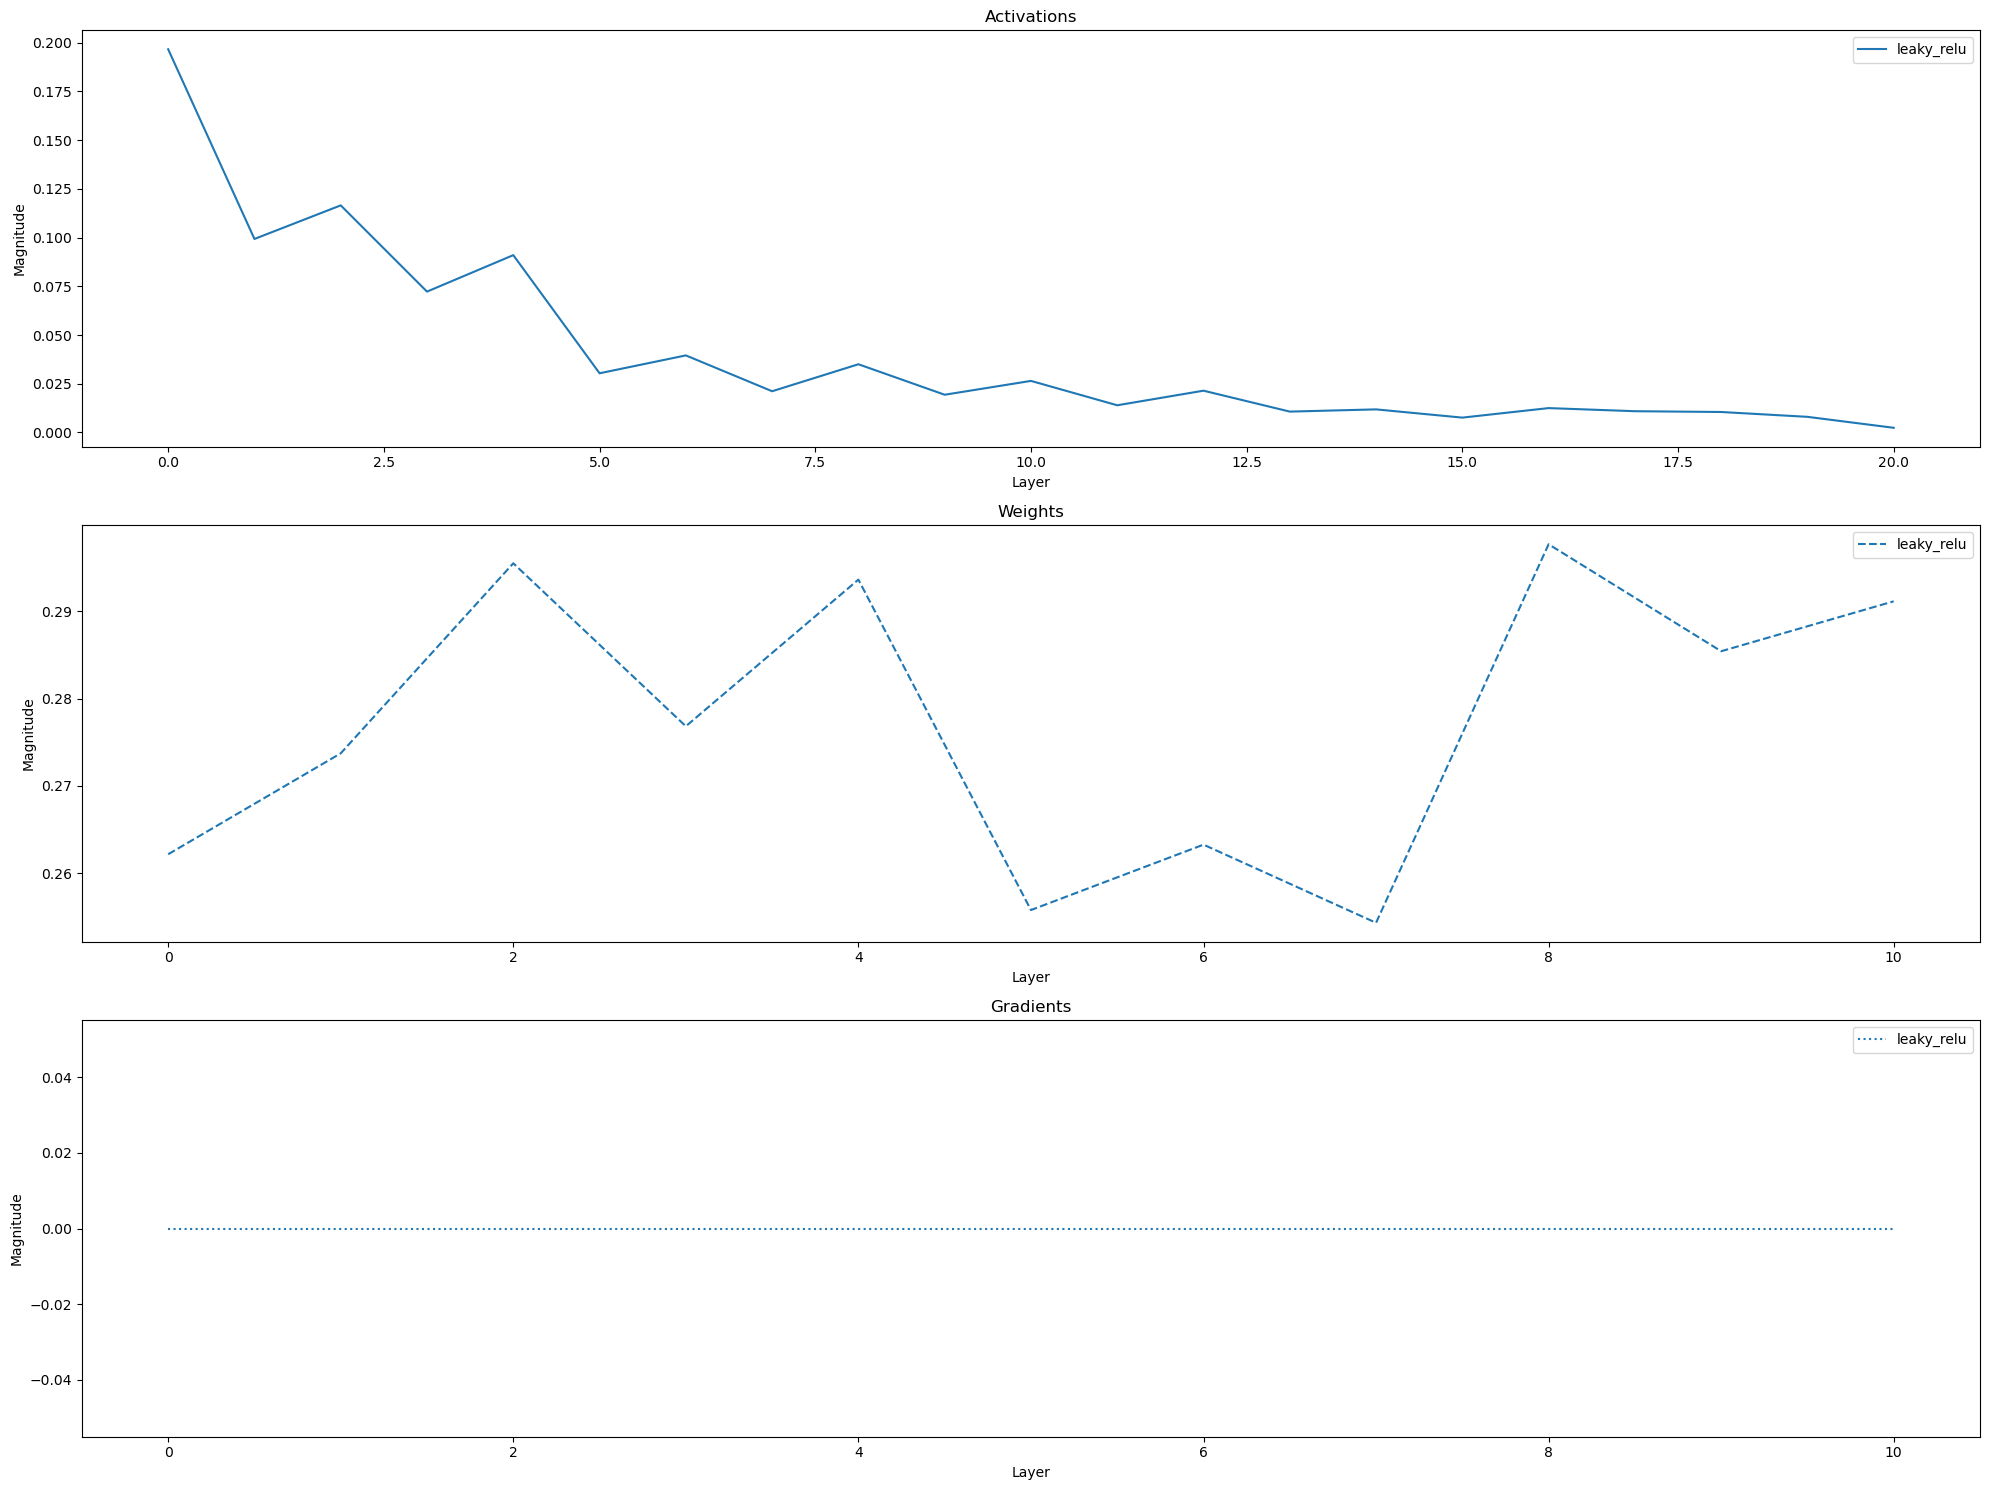


[SIGMOID] Extracting neuron activations (outputs) for input data [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]. This helps us understand how data flows through the network.

[RELU] Extracting neuron activations (outputs) for input data [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]. This helps us understand how data flows through the network.

[TANH] Extracting neuron activations (outputs) for input data [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]. This helps us understand how data flows through the network.

[SIGMOID] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[RELU] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[TANH] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.

[SIGMOID] Computing gradients to understand how much the error will change if the weights are adjusted. This is crucial for learning.

[SIGMOID] Re

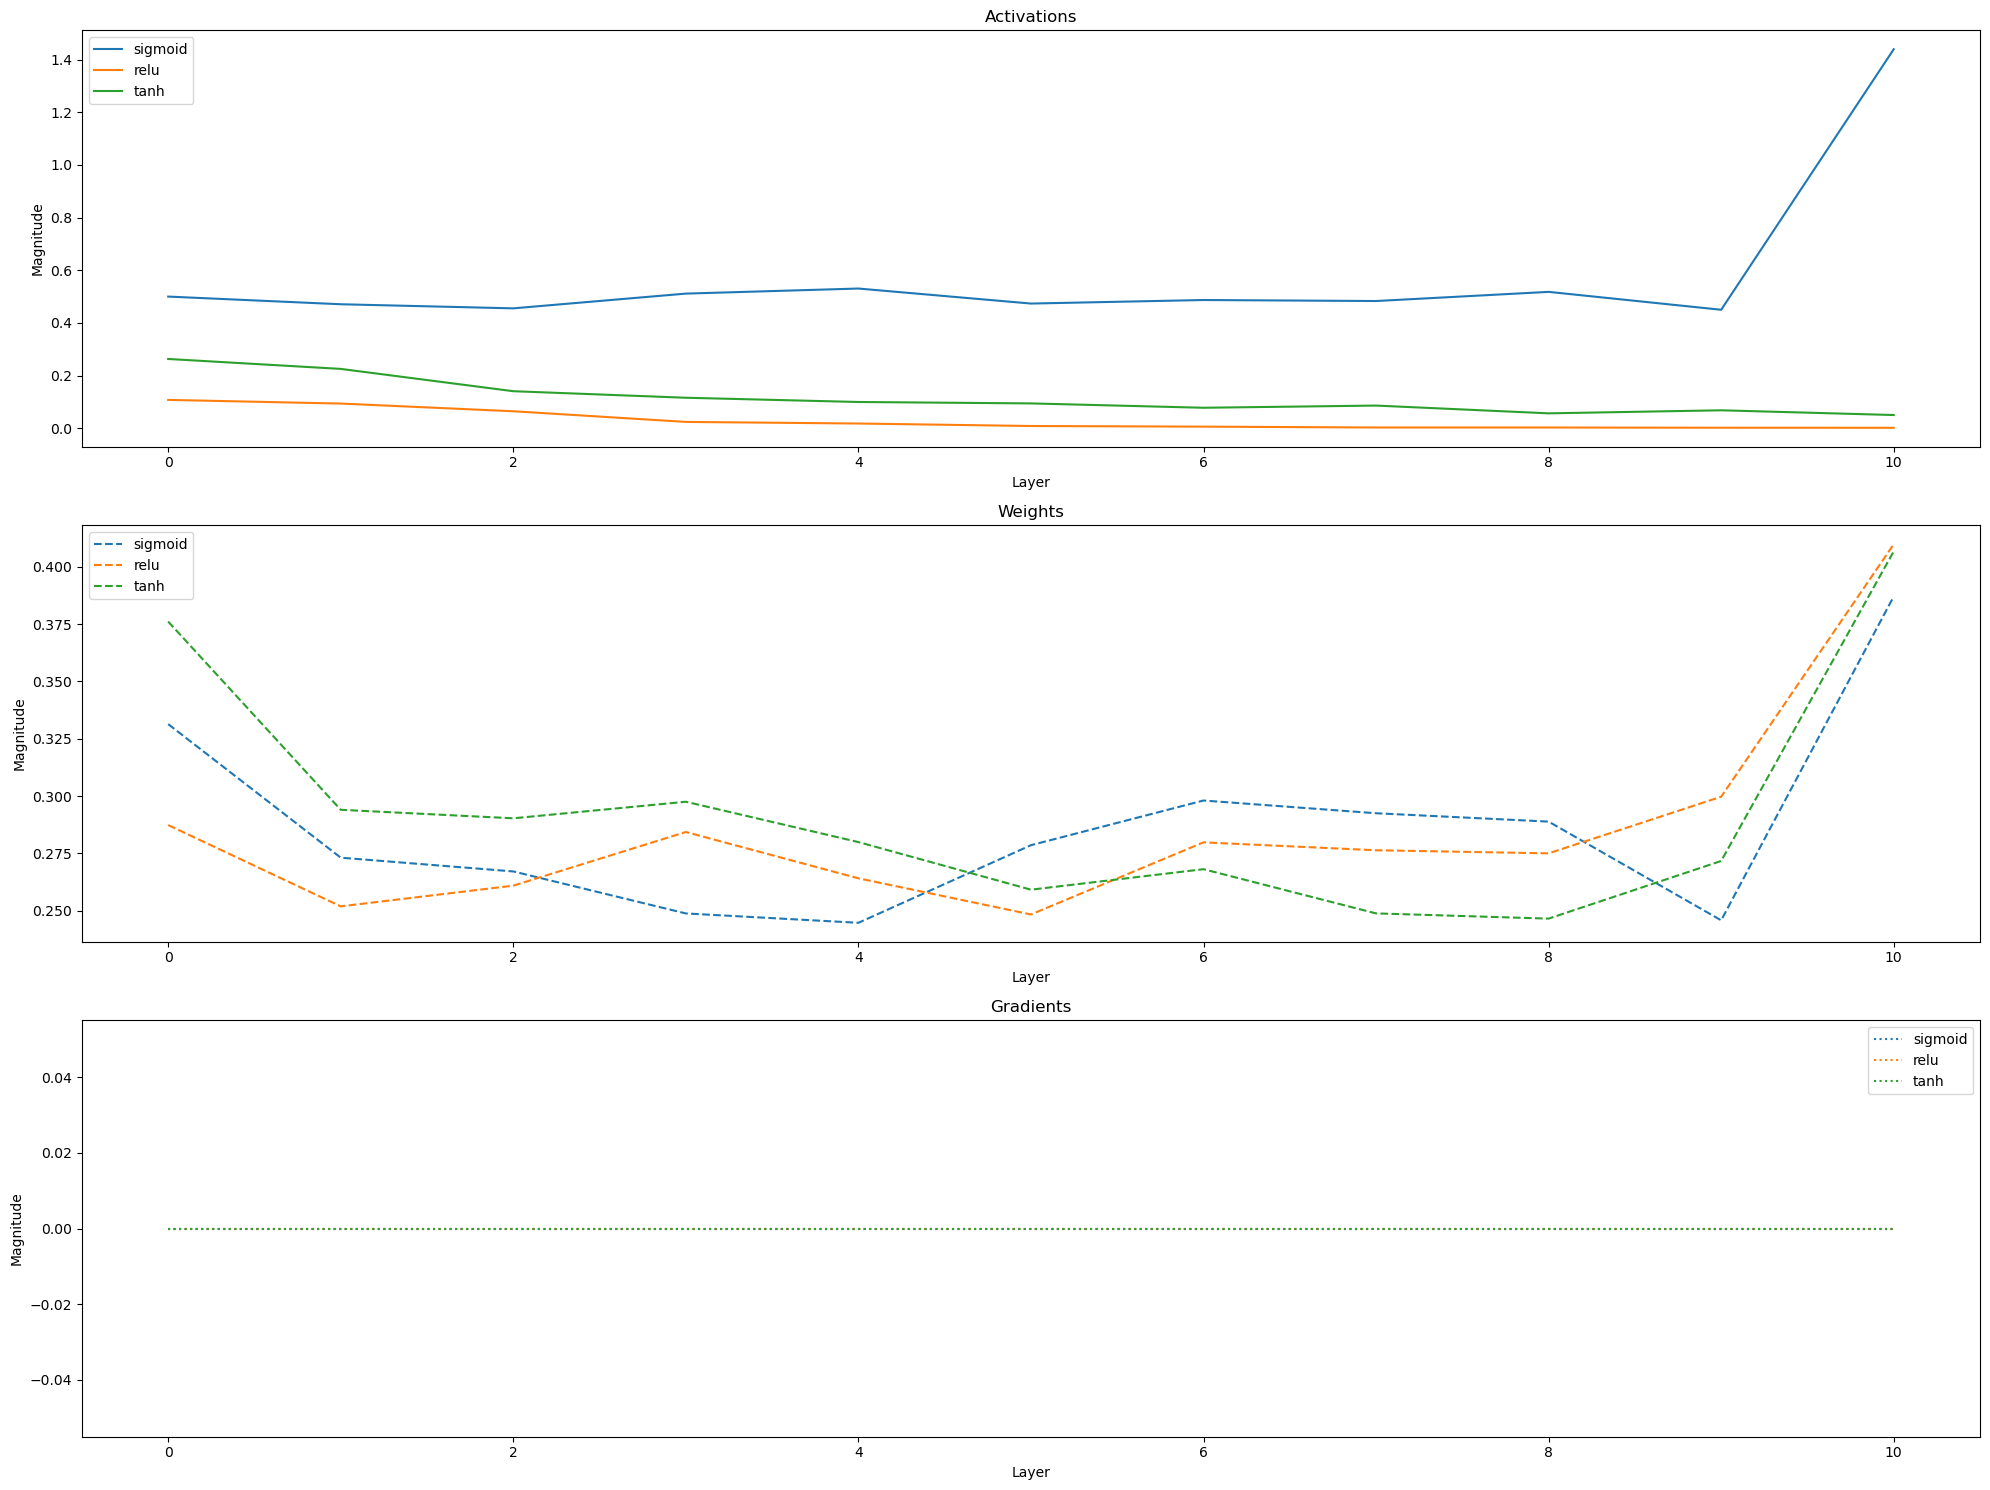

In [1]:
import os
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LeakyReLU

# Suppress TensorFlow logs and Python warnings for clearer output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def create_network(activation, layers, units, output_units):
    """ Create a neural network model based on the given activation function."""
    model = tf.keras.Sequential()
    
    for _ in range(layers):
        if activation == 'leaky_relu':
            model.add(Dense(units))
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Dense(units, activation=activation))
            
    model.add(Dense(output_units))
    model.build(input_shape=(None, 1))
    return model

def get_activations_for_model(model, data, activation_type):
    """Extract activations for the given data."""
    print(f"\n[{activation_type.upper()}] Extracting neuron activations (outputs) for input data {data.numpy()}. This helps us understand how data flows through the network.")
    return [tf.keras.Model(inputs=model.input, outputs=layer.output).predict(data, verbose=0) for layer in model.layers]

def get_weights_for_model(model, activation_type):
    """Extract weights from the model."""
    print(f"\n[{activation_type.upper()}] Retrieving the learned weights from the model. These weights represent the strength of connections between neurons.")
    return [layer.get_weights()[0] for layer in model.layers if layer.get_weights()]

def compute_gradients(model, data, activation_type):
    """Compute gradients for the given data."""
    print(f"\n[{activation_type.upper()}] Computing gradients to understand how much the error will change if the weights are adjusted. This is crucial for learning.")
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(data)
        predictions = model(data)
    
    gradient_input = tape.gradient(predictions, data).numpy()
    weights_tf = [tf.convert_to_tensor(weight) for weight in get_weights_for_model(model, activation_type)]
    gradient_weights = [tape.gradient(predictions, weight).numpy() if tape.gradient(predictions, weight) else np.zeros_like(weight.numpy()) for weight in weights_tf]
    del tape
    return gradient_input, gradient_weights

def identify_gradient_issues(gradient_weights, activation_type):
    """Identify potential gradient issues."""
    print(f"\n[{activation_type.upper()}] Checking for potential gradient issues like vanishing or exploding gradients which can hinder learning.")
    gradient_issues = {"vanishing": [], "exploding": []}
    for idx, gradient in enumerate(gradient_weights):
        if np.linalg.norm(gradient) < 1e-5:
            gradient_issues["vanishing"].append(idx)
        elif np.linalg.norm(gradient) > 1e3:
            gradient_issues["exploding"].append(idx)
    return gradient_issues

def plot_function(data, label, title, linestyle='-'):
    """Plot the function based on given data."""
    avg_magnitudes = [np.mean(np.abs(d)) for d in data]
    plt.plot(avg_magnitudes, label=label, linestyle=linestyle)

def plot_diagnostics(models, data):
    """Visualize the behavior of different activation functions."""
    plt.figure(figsize=(20, 15))
    diagnostics = [("Activations", '-'), ("Weights", '--'), ("Gradients", ':')]
    
    for idx, (title, linestyle) in enumerate(diagnostics, 1):
        plt.subplot(3, 1, idx)
        for activation_type, model in models.items():
            if title == "Activations":
                data_to_plot = get_activations_for_model(model, data, activation_type)  # pass the activation_type here
            elif title == "Weights":
                data_to_plot = get_weights_for_model(model, activation_type)  # and here
            else:
                _, gradient_weights = compute_gradients(model, data, activation_type)  # and here
                data_to_plot = gradient_weights
            
            plot_function(data_to_plot, activation_type, title, linestyle)
        
        plt.xlabel('Layer')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.legend()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.tight_layout()
    
    for activation_type, model in models.items():
        _, gradient_weights = compute_gradients(model, data, activation_type)  # and here
        gradient_issues = identify_gradient_issues(gradient_weights, activation_type)  # and here
        if gradient_issues["vanishing"]:
            print(f"[Warning] {activation_type} has potential vanishing gradient issues at layers: {gradient_issues['vanishing']}")
        if gradient_issues["exploding"]:
            print(f"[Warning] {activation_type} has potential exploding gradient issues at layers: {gradient_issues['exploding']}")
    
    plt.show()


# Dedicated analysis for Leaky ReLU
leaky_relu_model = create_network('leaky_relu', 10, 10, 1)
data_batch = tf.constant([[1.0], [0.5], [-1.0], [-0.5]])
plot_diagnostics({'leaky_relu': leaky_relu_model}, data_batch)

# Comparison with other activation functions
ACTIVATIONS = ['sigmoid', 'relu', 'tanh']
models_dict = {activation: create_network(activation, 10, 10, 1) for activation in ACTIVATIONS}
plot_diagnostics(models_dict, data_batch)


Analysis for SIGMOID Activation
----------------------------------------


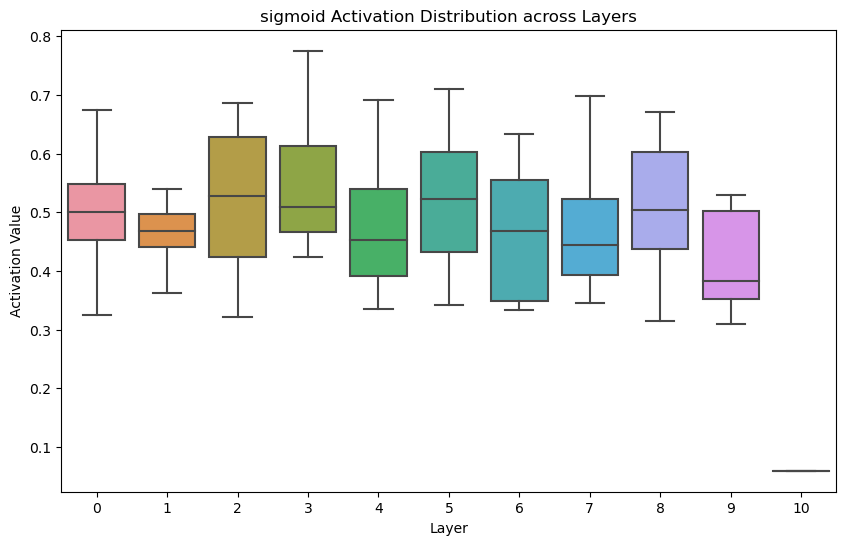

Layer 1 - Mean Activation: 0.5000, Standard Deviation: 0.0764
Layer 2 - Mean Activation: 0.4636, Standard Deviation: 0.0445
Layer 3 - Mean Activation: 0.5191, Standard Deviation: 0.1160
Layer 4 - Mean Activation: 0.5417, Standard Deviation: 0.1038
Layer 5 - Mean Activation: 0.4756, Standard Deviation: 0.1027
Layer 6 - Mean Activation: 0.5205, Standard Deviation: 0.1183
Layer 7 - Mean Activation: 0.4609, Standard Deviation: 0.1055
Layer 8 - Mean Activation: 0.4685, Standard Deviation: 0.0971
Layer 9 - Mean Activation: 0.5138, Standard Deviation: 0.1036
Layer 10 - Mean Activation: 0.4116, Standard Deviation: 0.0773
Layer 11 - Mean Activation: 0.0595, Standard Deviation: 0.0000


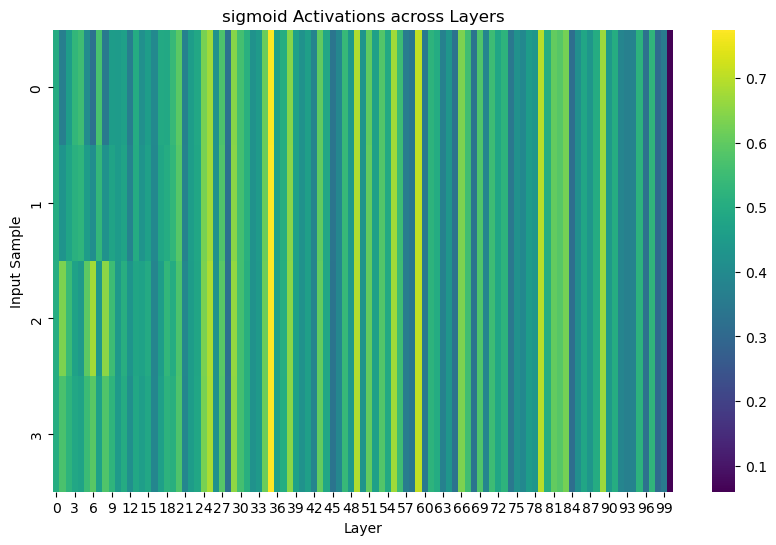

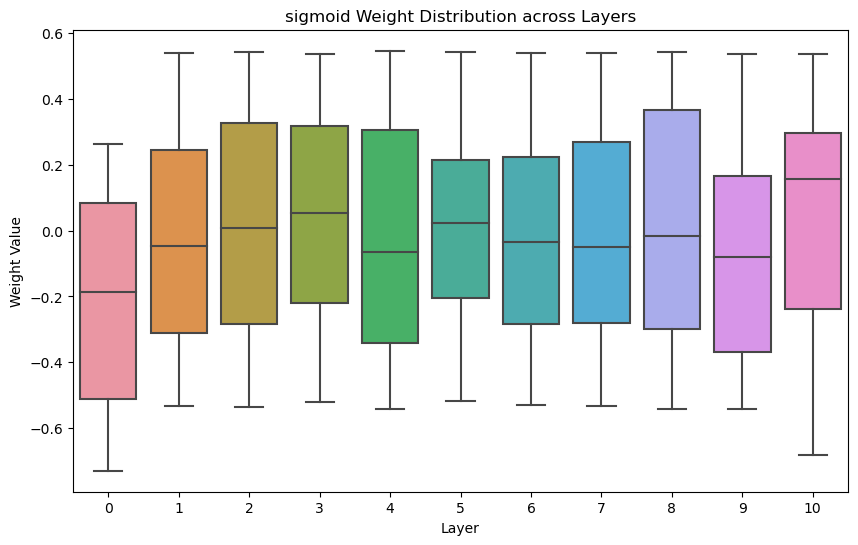

Layer 1 - Mean Weight: -0.2080, Standard Deviation: 0.3370
Layer 2 - Mean Weight: -0.0295, Standard Deviation: 0.3006
Layer 3 - Mean Weight: 0.0153, Standard Deviation: 0.3331
Layer 4 - Mean Weight: 0.0370, Standard Deviation: 0.2977
Layer 5 - Mean Weight: -0.0247, Standard Deviation: 0.3316
Layer 6 - Mean Weight: 0.0133, Standard Deviation: 0.2928
Layer 7 - Mean Weight: -0.0243, Standard Deviation: 0.3044
Layer 8 - Mean Weight: -0.0222, Standard Deviation: 0.3145
Layer 9 - Mean Weight: 0.0184, Standard Deviation: 0.3416
Layer 10 - Mean Weight: -0.0737, Standard Deviation: 0.3094
Layer 11 - Mean Weight: 0.0196, Standard Deviation: 0.4079


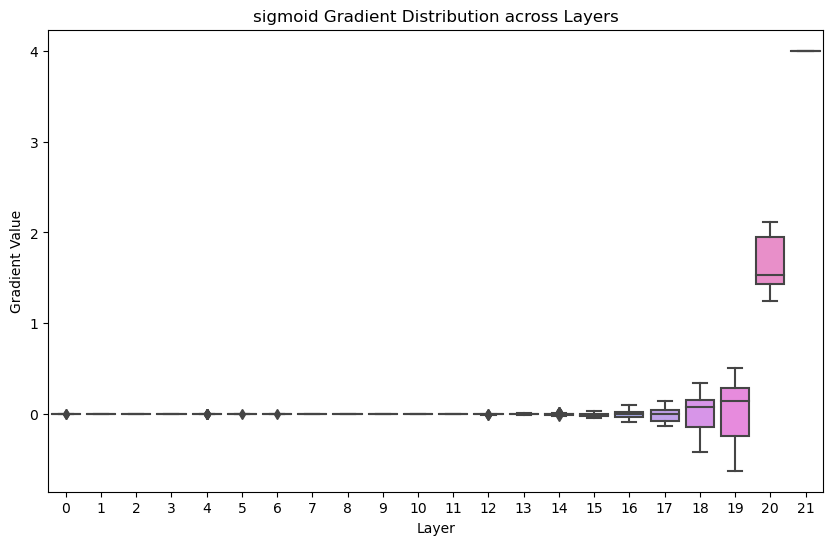

Layer 1 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 2 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 3 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 4 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 5 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 6 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 7 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 8 - Mean Gradient: -0.0000, Standard Deviation: 0.0001
Layer 9 - Mean Gradient: -0.0000, Standard Deviation: 0.0001
Layer 10 - Mean Gradient: -0.0001, Standard Deviation: 0.0002
Layer 11 - Mean Gradient: 0.0001, Standard Deviation: 0.0005
Layer 12 - Mean Gradient: 0.0001, Standard Deviation: 0.0011
Layer 13 - Mean Gradient: 0.0003, Standard Deviation: 0.0021
Layer 14 - Mean Gradient: 0.0006, Standard Deviation: 0.0040
Layer 15 - Mean Gradient: -0.0031, Standard Deviation: 0.0093
Layer 16 - Mean Gradient: -0.0067, Standard Deviation: 0.0196
Layer 17 - Mean Gradien

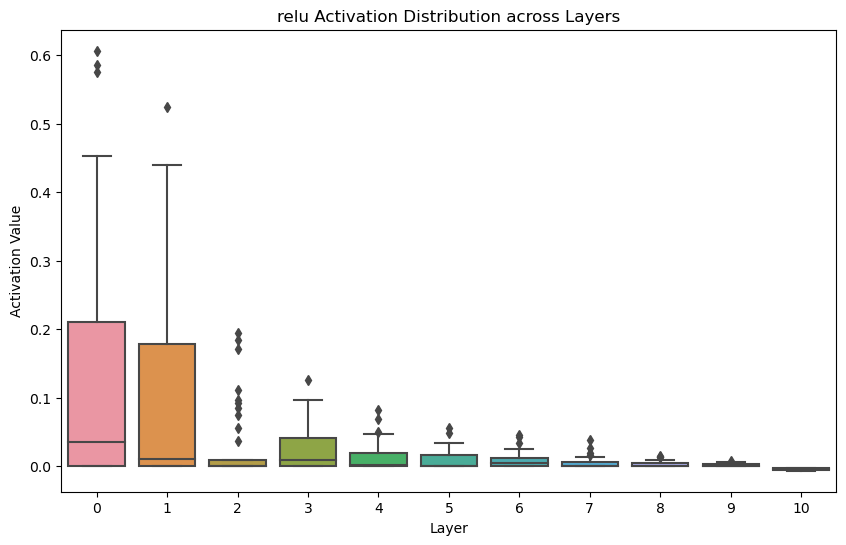

Layer 1 - Mean Activation: 0.1338, Standard Deviation: 0.1776
Layer 2 - Mean Activation: 0.1026, Standard Deviation: 0.1473
Layer 3 - Mean Activation: 0.0275, Standard Deviation: 0.0543
Layer 4 - Mean Activation: 0.0237, Standard Deviation: 0.0315
Layer 5 - Mean Activation: 0.0130, Standard Deviation: 0.0199
Layer 6 - Mean Activation: 0.0099, Standard Deviation: 0.0144
Layer 7 - Mean Activation: 0.0086, Standard Deviation: 0.0116
Layer 8 - Mean Activation: 0.0047, Standard Deviation: 0.0081
Layer 9 - Mean Activation: 0.0027, Standard Deviation: 0.0042
Layer 10 - Mean Activation: 0.0014, Standard Deviation: 0.0019
Layer 11 - Mean Activation: -0.0041, Standard Deviation: 0.0016


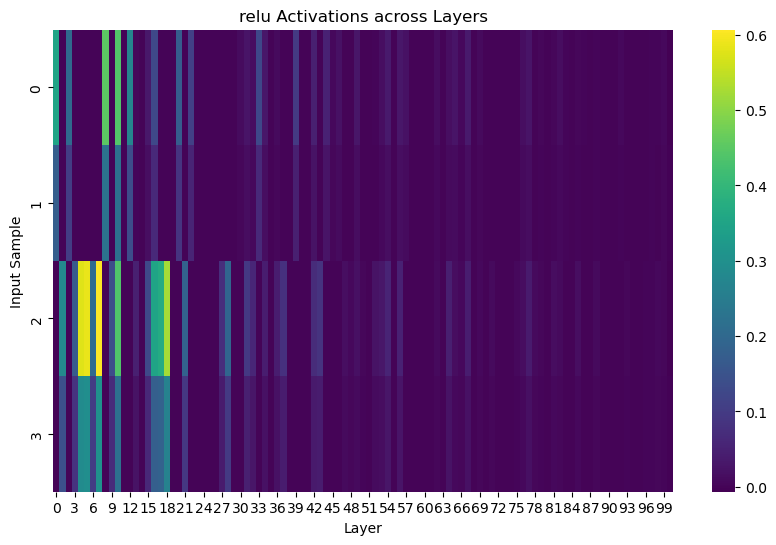

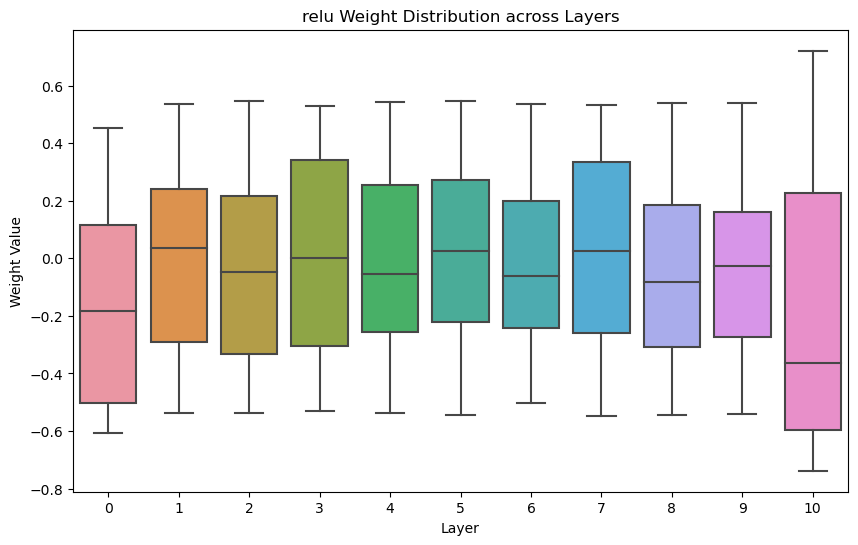

Layer 1 - Mean Weight: -0.1556, Standard Deviation: 0.3661
Layer 2 - Mean Weight: 0.0052, Standard Deviation: 0.3278
Layer 3 - Mean Weight: -0.0363, Standard Deviation: 0.3087
Layer 4 - Mean Weight: 0.0066, Standard Deviation: 0.3290
Layer 5 - Mean Weight: -0.0002, Standard Deviation: 0.3311
Layer 6 - Mean Weight: 0.0093, Standard Deviation: 0.2985
Layer 7 - Mean Weight: -0.0120, Standard Deviation: 0.2993
Layer 8 - Mean Weight: 0.0171, Standard Deviation: 0.3211
Layer 9 - Mean Weight: -0.0397, Standard Deviation: 0.3104
Layer 10 - Mean Weight: -0.0339, Standard Deviation: 0.2871
Layer 11 - Mean Weight: -0.1657, Standard Deviation: 0.5056


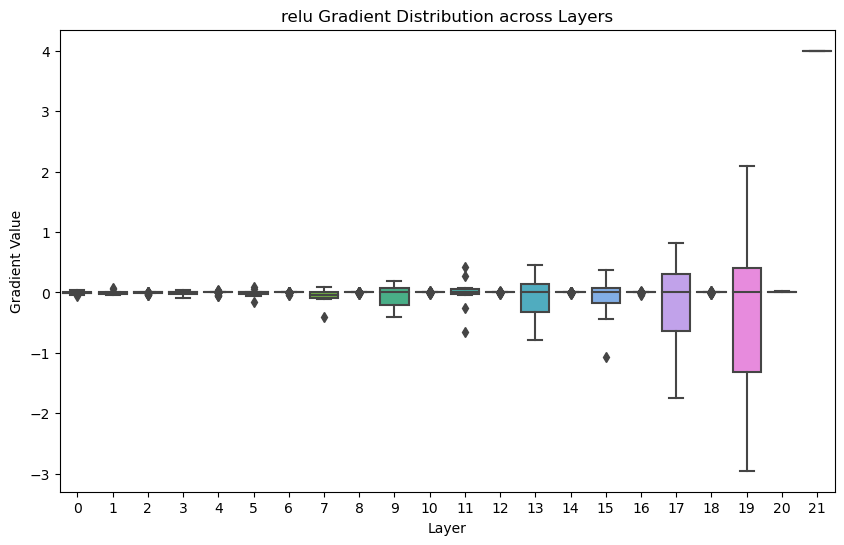

Layer 1 - Mean Gradient: -0.0046, Standard Deviation: 0.0274
Layer 2 - Mean Gradient: -0.0008, Standard Deviation: 0.0370
Layer 3 - Mean Gradient: -0.0025, Standard Deviation: 0.0088
Layer 4 - Mean Gradient: -0.0153, Standard Deviation: 0.0380
Layer 5 - Mean Gradient: -0.0008, Standard Deviation: 0.0127
Layer 6 - Mean Gradient: -0.0104, Standard Deviation: 0.0636
Layer 7 - Mean Gradient: -0.0016, Standard Deviation: 0.0079
Layer 8 - Mean Gradient: -0.0611, Standard Deviation: 0.1305
Layer 9 - Mean Gradient: -0.0015, Standard Deviation: 0.0065
Layer 10 - Mean Gradient: -0.0646, Standard Deviation: 0.1833
Layer 11 - Mean Gradient: -0.0001, Standard Deviation: 0.0063
Layer 12 - Mean Gradient: -0.0168, Standard Deviation: 0.2756
Layer 13 - Mean Gradient: -0.0006, Standard Deviation: 0.0057
Layer 14 - Mean Gradient: -0.0666, Standard Deviation: 0.3727
Layer 15 - Mean Gradient: -0.0007, Standard Deviation: 0.0050
Layer 16 - Mean Gradient: -0.1035, Standard Deviation: 0.3836
Layer 17 - Mean G

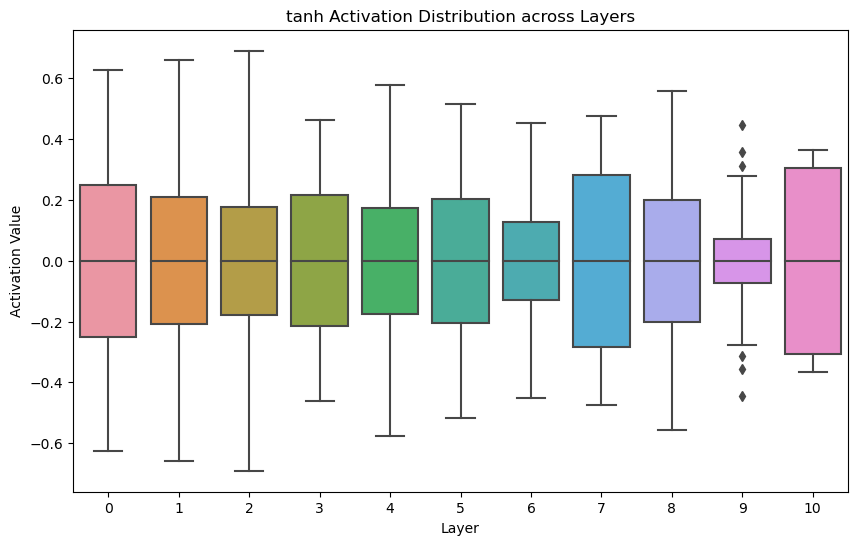

Layer 1 - Mean Activation: 0.0000, Standard Deviation: 0.3302
Layer 2 - Mean Activation: -0.0000, Standard Deviation: 0.3221
Layer 3 - Mean Activation: 0.0000, Standard Deviation: 0.2892
Layer 4 - Mean Activation: -0.0000, Standard Deviation: 0.2577
Layer 5 - Mean Activation: 0.0000, Standard Deviation: 0.2767
Layer 6 - Mean Activation: 0.0000, Standard Deviation: 0.2590
Layer 7 - Mean Activation: -0.0000, Standard Deviation: 0.2205
Layer 8 - Mean Activation: 0.0000, Standard Deviation: 0.3035
Layer 9 - Mean Activation: -0.0000, Standard Deviation: 0.2443
Layer 10 - Mean Activation: 0.0000, Standard Deviation: 0.1909
Layer 11 - Mean Activation: 0.0000, Standard Deviation: 0.3285


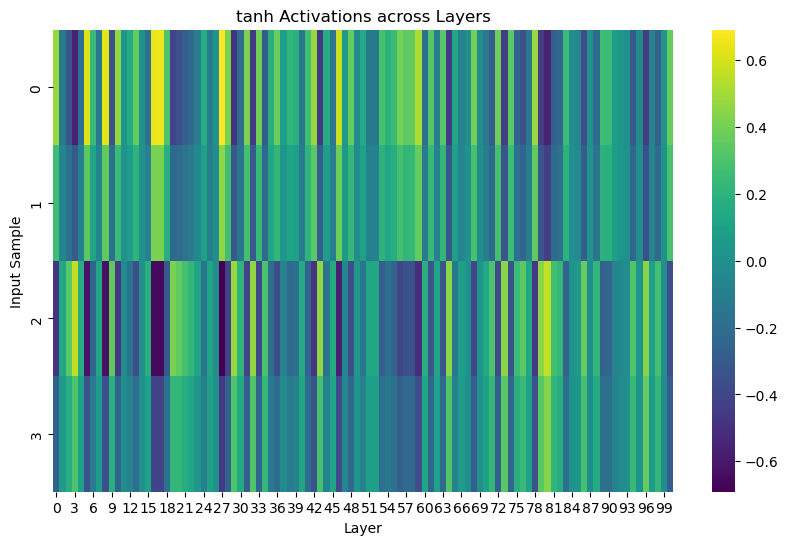

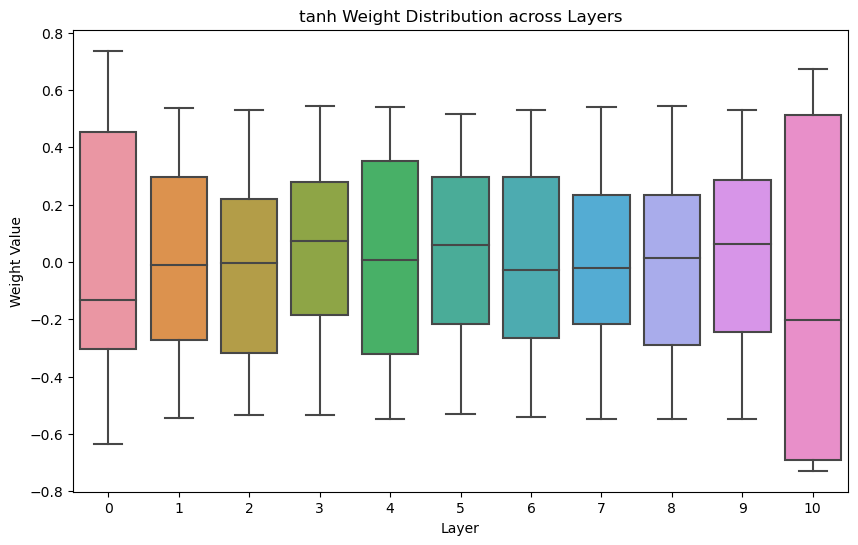

Layer 1 - Mean Weight: 0.0437, Standard Deviation: 0.4588
Layer 2 - Mean Weight: 0.0098, Standard Deviation: 0.3310
Layer 3 - Mean Weight: -0.0264, Standard Deviation: 0.3087
Layer 4 - Mean Weight: 0.0408, Standard Deviation: 0.2993
Layer 5 - Mean Weight: 0.0092, Standard Deviation: 0.3415
Layer 6 - Mean Weight: 0.0371, Standard Deviation: 0.2940
Layer 7 - Mean Weight: -0.0007, Standard Deviation: 0.3185
Layer 8 - Mean Weight: -0.0033, Standard Deviation: 0.3003
Layer 9 - Mean Weight: -0.0051, Standard Deviation: 0.3195
Layer 10 - Mean Weight: 0.0258, Standard Deviation: 0.3165
Layer 11 - Mean Weight: -0.1068, Standard Deviation: 0.5798


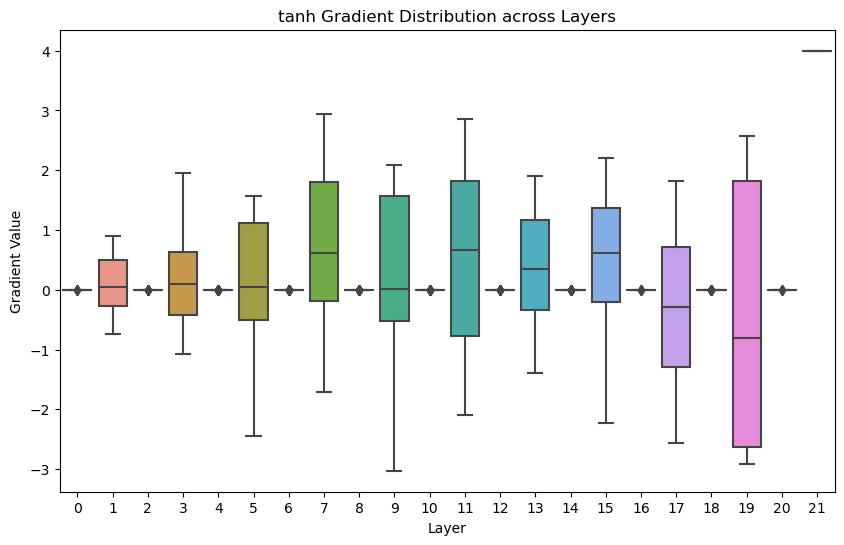

Layer 1 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 2 - Mean Gradient: 0.0965, Standard Deviation: 0.5276
Layer 3 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 4 - Mean Gradient: 0.2037, Standard Deviation: 0.8523
Layer 5 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 6 - Mean Gradient: 0.0688, Standard Deviation: 1.1662
Layer 7 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 8 - Mean Gradient: 0.6635, Standard Deviation: 1.4517
Layer 9 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 10 - Mean Gradient: 0.1955, Standard Deviation: 1.4774
Layer 11 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 12 - Mean Gradient: 0.4635, Standard Deviation: 1.5491
Layer 13 - Mean Gradient: -0.0000, Standard Deviation: 0.0000
Layer 14 - Mean Gradient: 0.2819, Standard Deviation: 1.0743
Layer 15 - Mean Gradient: 0.0000, Standard Deviation: 0.0000
Layer 16 - Mean Gradient: 0.4404, Standard Deviation: 1.3195
Layer 17 - Mean Gradient: -0.00

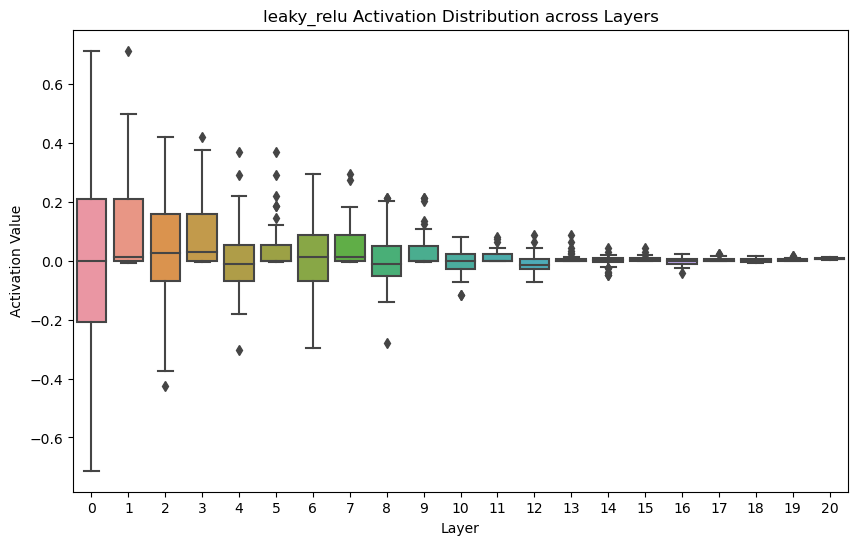

Layer 1 - Mean Activation: -0.0000, Standard Deviation: 0.3056
Layer 2 - Mean Activation: 0.1221, Standard Deviation: 0.1783
Layer 3 - Mean Activation: 0.0360, Standard Deviation: 0.1828
Layer 4 - Mean Activation: 0.0918, Standard Deviation: 0.1157
Layer 5 - Mean Activation: 0.0051, Standard Deviation: 0.1273
Layer 6 - Mean Activation: 0.0483, Standard Deviation: 0.0882
Layer 7 - Mean Activation: 0.0167, Standard Deviation: 0.1202
Layer 8 - Mean Activation: 0.0550, Standard Deviation: 0.0769
Layer 9 - Mean Activation: 0.0039, Standard Deviation: 0.0978
Layer 10 - Mean Activation: 0.0382, Standard Deviation: 0.0622
Layer 11 - Mean Activation: -0.0037, Standard Deviation: 0.0434
Layer 12 - Mean Activation: 0.0147, Standard Deviation: 0.0214
Layer 13 - Mean Activation: -0.0097, Standard Deviation: 0.0321
Layer 14 - Mean Activation: 0.0082, Standard Deviation: 0.0186
Layer 15 - Mean Activation: -0.0015, Standard Deviation: 0.0189
Layer 16 - Mean Activation: 0.0056, Standard Deviation: 0.00

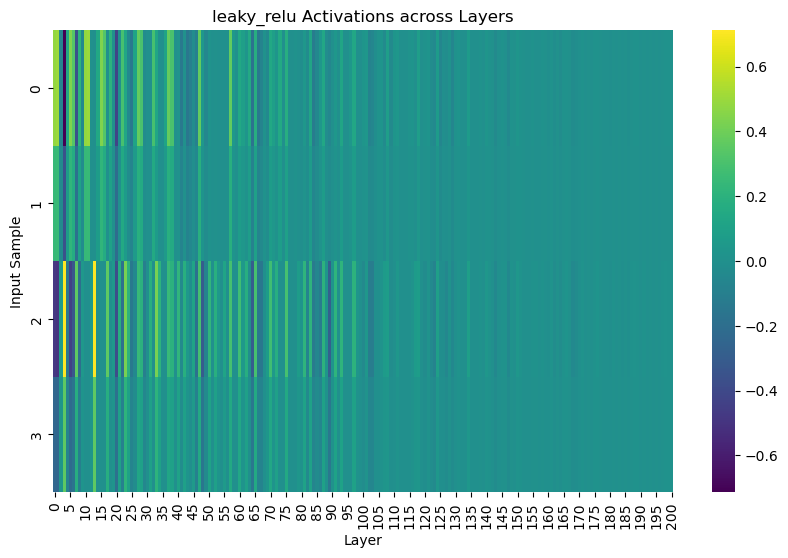

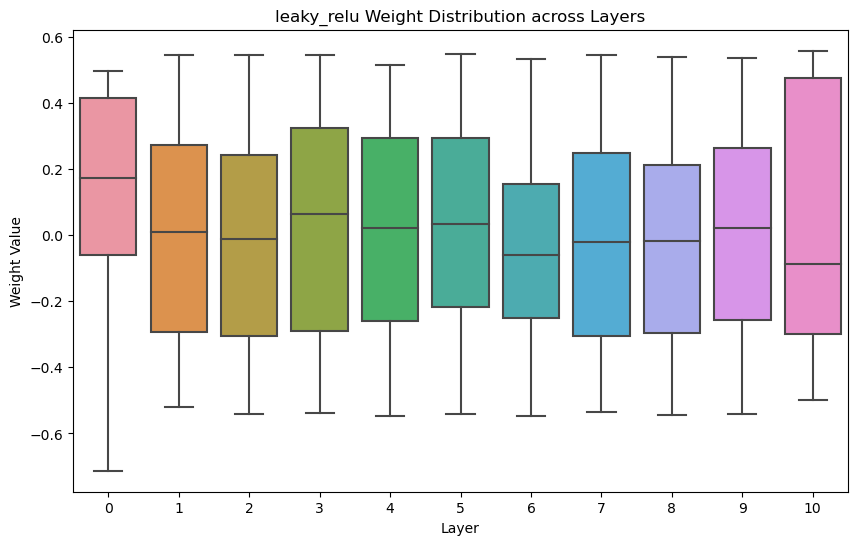

Layer 1 - Mean Weight: 0.0917, Standard Deviation: 0.3756
Layer 2 - Mean Weight: -0.0040, Standard Deviation: 0.3316
Layer 3 - Mean Weight: -0.0391, Standard Deviation: 0.3272
Layer 4 - Mean Weight: 0.0179, Standard Deviation: 0.3317
Layer 5 - Mean Weight: 0.0106, Standard Deviation: 0.3163
Layer 6 - Mean Weight: 0.0315, Standard Deviation: 0.2897
Layer 7 - Mean Weight: -0.0449, Standard Deviation: 0.3000
Layer 8 - Mean Weight: -0.0254, Standard Deviation: 0.3223
Layer 9 - Mean Weight: -0.0266, Standard Deviation: 0.3126
Layer 10 - Mean Weight: 0.0079, Standard Deviation: 0.2953
Layer 11 - Mean Weight: 0.0351, Standard Deviation: 0.3952


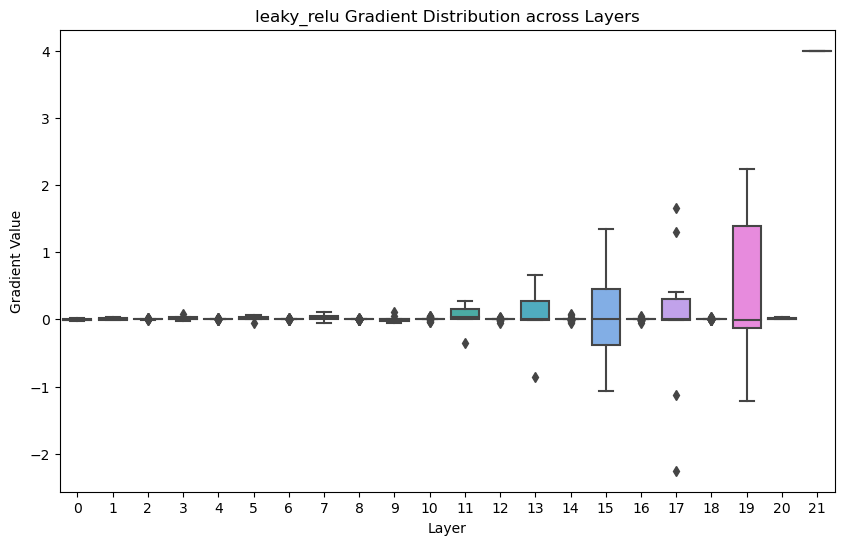

Layer 1 - Mean Gradient: -0.0009, Standard Deviation: 0.0102
Layer 2 - Mean Gradient: 0.0059, Standard Deviation: 0.0128
Layer 3 - Mean Gradient: 0.0019, Standard Deviation: 0.0045
Layer 4 - Mean Gradient: 0.0152, Standard Deviation: 0.0271
Layer 5 - Mean Gradient: 0.0012, Standard Deviation: 0.0046
Layer 6 - Mean Gradient: 0.0133, Standard Deviation: 0.0319
Layer 7 - Mean Gradient: 0.0012, Standard Deviation: 0.0047
Layer 8 - Mean Gradient: 0.0261, Standard Deviation: 0.0464
Layer 9 - Mean Gradient: 0.0004, Standard Deviation: 0.0041
Layer 10 - Mean Gradient: 0.0060, Standard Deviation: 0.0438
Layer 11 - Mean Gradient: 0.0024, Standard Deviation: 0.0119
Layer 12 - Mean Gradient: 0.0511, Standard Deviation: 0.1673
Layer 13 - Mean Gradient: 0.0009, Standard Deviation: 0.0089
Layer 14 - Mean Gradient: 0.0607, Standard Deviation: 0.3810
Layer 15 - Mean Gradient: 0.0007, Standard Deviation: 0.0139
Layer 16 - Mean Gradient: 0.0771, Standard Deviation: 0.7305
Layer 17 - Mean Gradient: -0.000

In [2]:
import os
import warnings
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LeakyReLU

# Suppress TensorFlow logs and Python warnings for clearer output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def create_network(activation, layers, units, output_units):
    """ 
    Create a neural network model based on the given activation function.
    """
    model = tf.keras.Sequential()
    
    for _ in range(layers):
        if activation == 'leaky_relu':
            model.add(Dense(units))
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Dense(units, activation=activation))
            
    model.add(Dense(output_units))
    model.build(input_shape=(None, 1))
    return model

def get_activations_for_model(model, data):
    """
    Extract activations for the given data.
    """
    return [tf.keras.Model(inputs=model.input, outputs=layer.output).predict(data, verbose=0) for layer in model.layers]

def get_weights_for_model(model):
    """
    Extract weights from the model.
    """
    return [layer.get_weights()[0] for layer in model.layers if layer.get_weights()]

def compute_gradients(model, data):
    """
    Compute gradients for the given data.
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(data)
        predictions = model(data)
    
    gradient_input = tape.gradient(predictions, data)
    gradient_weights = []
    
    for layer in model.layers:
        weights = layer.trainable_weights  # Ensure we only consider trainable weights
        if weights:
            gradients = tape.gradient(predictions, weights)
            gradient_weights.extend(gradients)
    
    return gradient_input, gradient_weights


def plot_activations(activation_type, model, data):
    """
    Plot activations for the given model and data.
    """
    activations = get_activations_for_model(model, data)
    for idx, activation in enumerate(activations):
        plt.figure(figsize=(6, 4))
        plt.hist(activation, bins=50)
        plt.title(f"{activation_type} Activations in Layer {idx+1}")
        plt.xlabel("Activation Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_weights(activation_type, model):
    """
    Plot weight distributions for the given model.
    """
    weights = get_weights_for_model(model)
    for idx, weight in enumerate(weights):
        plt.figure(figsize=(6, 4))
        plt.hist(weight.flatten(), bins=50)
        plt.title(f"{activation_type} Weights in Layer {idx+1}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_gradients(activation_type, model, data):
    """
    Plot gradients for the given model and data.
    """
    _, gradient_weights = compute_gradients(model, data)
    fig, axes = plt.subplots(1, len(gradient_weights), figsize=(6 * len(gradient_weights), 4))
    for idx, gradient in enumerate(gradient_weights):
        if len(gradient_weights) > 1:
            ax = axes[idx]
        else:
            ax = axes
        ax.hist(gradient.numpy().flatten(), bins=50)
        ax.set_title(f"{activation_type} Gradients in Layer {idx+1}")
        ax.set_xlabel("Gradient Value")
        ax.set_ylabel("Frequency")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_summary(data_list, title, data_type):
    """
    Plot boxplots and summary statistics for activations, weights, or gradients.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    if isinstance(data_list[0], tf.Tensor):  # Check if the data is still in tensor format
        sns.boxplot(data=[d.numpy().flatten() for d in data_list], ax=ax)
    else:
        sns.boxplot(data=[d.flatten() for d in data_list], ax=ax)  # For numpy arrays
    ax.set_title(f"{title} {data_type} Distribution across Layers")
    ax.set_xlabel("Layer")
    ax.set_ylabel(f"{data_type} Value")
    plt.show()

    # Display summary statistics
    for idx, data in enumerate(data_list):
        if isinstance(data, tf.Tensor):  # Check if the data is still in tensor format
            mean_val = np.mean(data.numpy())
            std_val = np.std(data.numpy())
        else:
            mean_val = np.mean(data)
            std_val = np.std(data)
        print(f"Layer {idx+1} - Mean {data_type}: {mean_val:.4f}, Standard Deviation: {std_val:.4f}")

def plot_activations_heatmap(activation_type, model, data):
    """
    Plot heatmap for activations across layers for multiple inputs.
    """
    activations = get_activations_for_model(model, data)
    
    # Check if activations are in tensor format or numpy arrays
    if isinstance(activations[0], tf.Tensor):
        activations_matrix = np.hstack([act.numpy() for act in activations])
    else:
        activations_matrix = np.hstack(activations)  # Directly stack if already numpy arrays
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(activations_matrix, cmap='viridis', cbar=True)
    plt.title(f"{activation_type} Activations across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Input Sample")
    plt.show()

def analyze_networks(models, data):
    """
    Analyze activations, weights, and gradients for all models.
    """
    for activation_type, model in models.items():
        print(f"\nAnalysis for {activation_type.upper()} Activation\n{'-'*40}")
        
        activations = get_activations_for_model(model, data)
        plot_summary(activations, activation_type, "Activation")
        plot_activations_heatmap(activation_type, model, data)

        weights = get_weights_for_model(model)
        plot_summary(weights, activation_type, "Weight")

        _, gradient_weights = compute_gradients(model, data)
        plot_summary(gradient_weights, activation_type, "Gradient")

        print("\n\n")

# Test the functions
ACTIVATIONS = ['sigmoid', 'relu', 'tanh', 'leaky_relu']
models_dict = {activation: create_network(activation, 10, 10, 1) for activation in ACTIVATIONS}
data_batch = tf.constant([[1.0], [0.5], [-1.0], [-0.5]])
analyze_networks(models_dict, data_batch)


# Why Leaky ReLU exhibits a distinct behavior?

- **No Zero Slope**: Unlike standard ReLU, Leaky ReLU retains a small gradient for negative inputs. This prevents 'dead neurons' – neurons that never activate.
  
- **Deep Networks**: Activation functions' effects intensify in deep networks. For sigmoid, gradients can vanish in deep layers due to minuscule gradient values. Standard ReLU's gradients can vanish for negative inputs or stay consistent for positive ones. However, Leaky ReLU's gradient remains slightly positive for negative inputs. __In deeper layers, these minute gradients can compound, resulting in significant activations__.

- **Initialization**: The manner in which weights and biases are initialized can sway activation behaviors. If initial conditions push Leaky ReLU's activations mostly towards negative values, growing network depth might amplify these activations, especially if negative values consistently pass through Leaky ReLU.

- **Network Design**: The overall architecture, encompassing neuron count, layer structure, and inter-neuronal connections, can modulate activation behaviors. Certain designs might amplify or suppress activations.

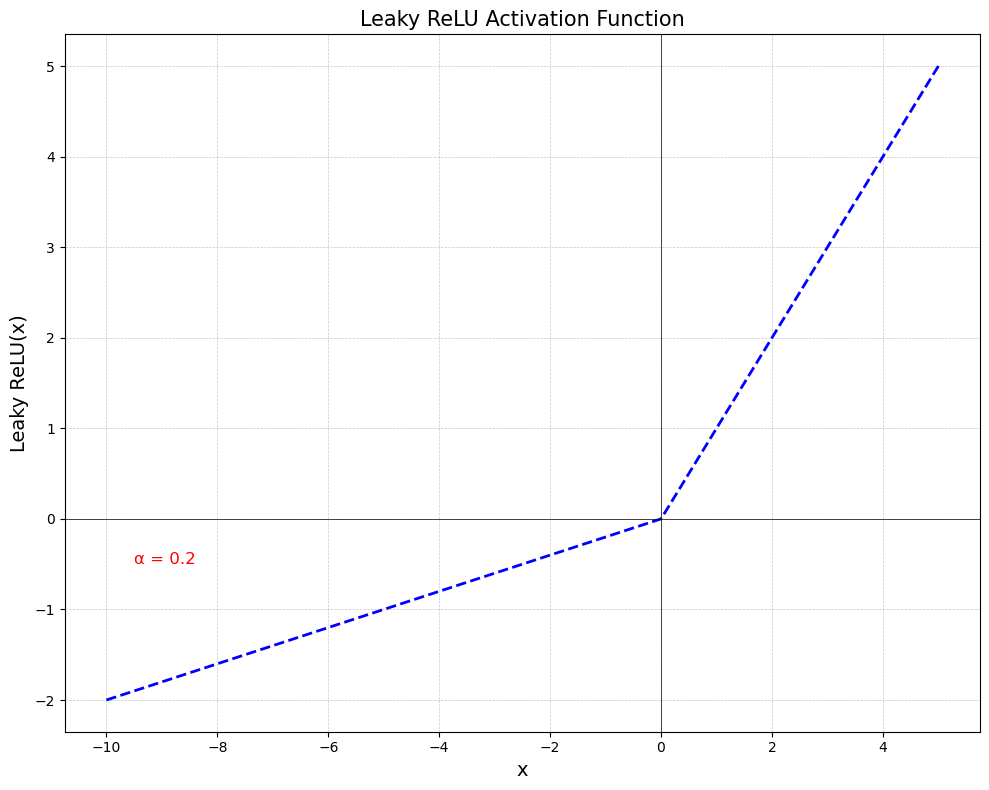

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def updated_leaky_relu_plot(alpha=0.2):
    # Define x range
    x = np.linspace(-10, 5, 600)

    # Compute Leaky ReLU values
    y = leaky_relu(x, alpha=alpha)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.plot(x, y, 'b--', linewidth=2)  # Dashed line style
    plt.title('Leaky ReLU Activation Function', fontsize=15)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('Leaky ReLU(x)', fontsize=14)  # Updated y-label
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Updated grid style
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)

    # Annotate the value of alpha
    plt.annotate(f'α = {alpha}', xy=(-9.5, -0.5), color='red', fontsize=12)

    plt.tight_layout()
    plt.show()

# Generate the updated plot
updated_leaky_relu_plot()

### Leaky ReLU introduces a slight slope for negative inputs, preventing neurons from becoming inactive, thus addressing the 'dying ReLU' problem in deep networks.
---
- **Positive Inputs**: Demonstrates linear behavior $f(x) = x$, facilitating unhindered gradient flow.
- **Negative Inputs**: Not flat like standard ReLU; has a slight slope, typically 0.01, determined by the $ \alpha $ parameter. Here, $\alpha = 0.2$.
- **Dead Neuron Mitigation**: The minimal slope ensures neurons remain active.
- **Continuity**: Leaky ReLU is continuous, but non-smooth at $ x=0$.
- **Extremal Behavior**: As $x$ tends to $ \pm \infty $, the function behavior is linear or gradually declining.

---

<h2 id="credits" style="color: #4CAF50;">🥇 Credits ⤵︎ </h2>
<h4 style="color: #2196F3;">For more information, visit the works of:</h4>
<ul style="list-style-type: square;">
  <li><a href="https://arxiv.org/pdf/2109.14545.pdf">Dubey, Singh, Chaudhuri. Activation Functions in Deep Learning: A Comprehensive Survey and Benchmark. Neurocomputing, 2021.</a></li>
  <li><a href="https://github.com/shivram1987/ActivationFunctions">GitHub: ActivationFunctions</a></li>
  <li><a href="https://medium.com/geekculture/different-activation-functions-for-deep-neural-networks-you-should-know-ea5e86f51e84">Medium: Different Activation Functions for Deep Neural Networks</a></li>
</ul>

<div style="background-color: #f2f2f2; padding: 53px; border-radius: 5px;">
  <h3>If you found this notebook helpful...</h3>
  <p>
  Please consider giving it a star. Your support helps me continue to develop high-quality code and pursue my career as a data analyst/engineer. Feedback is always welcome and appreciated. Thank you for taking the time to read my work! 
  </p> 
  <h4>
  <p style="text-align: right;">
  <a href="https://github.com/patmejia"> - pat [¬º-°]¬ </a>
  </h4>
  </p>
</div>